In [4]:
# 导入所需的包
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# 读取数据
attachment1 = pd.read_excel("CUMCM2023Problems/C题/6 个蔬菜品类的商品信息.xlsx")
attachment2 = pd.read_excel("CUMCM2023Problems/C题/销售流水明细数据.xlsx")
attachment3 = pd.read_excel("CUMCM2023Problems/C题/蔬菜类商品的批发价格.xlsx")

In [5]:
# costlist=attachment3.merge(attachment1,on='单品编码',how='left').groupby(['日期','分类名称']).mean()
# Pricelist=attachment2.merge(attachment1,on='单品编码',how='left').groupby(['销售日期','分类名称']).agg({'销量(千克)':'sum','销售单价(元/千克)':'mean'})


In [6]:
# for i,j in (costlist.groupby('分类名称'),Pricelist.groupby('分类名称')):
#     print(i[1]['批发价格(元/千克)'],j[1]['批发价格(元/千克)'])
#     print(j)

In [7]:
# attachment2.head()

首先，您需要对数据进行归一化，并将时间序列数据转换为LSTM可以处理的格式。

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Group by the date and product ID to get daily sales volume for each product
# Merge with attachment1 to get the category information/
daily_sales = attachment2.merge(attachment1, on='单品编码', how='left')

# Grouping the data by category and date
category_sales2 = daily_sales.groupby(['销售日期', '分类名称'])['销量(千克)'].mean().unstack()
category_sales2.replace(np.nan, 0, inplace=True)
category_sales = category_sales2['水生根茎类']

分类名称,水生根茎类,花叶类,花菜类,茄类,辣椒类,食用菌
销售日期,,,,,,
2020-07-01,0.323333,0.461578,0.452816,0.589567,0.296197,0.294708
2020-07-02,0.328571,0.468941,0.462558,0.574982,0.292319,0.303187
2020-07-03,0.319067,0.469899,0.438292,0.629754,0.283053,0.284846
2020-07-04,0.339938,0.449785,0.441762,0.576434,0.277413,0.276386
2020-07-05,0.334917,0.440746,0.523340,0.556901,0.279818,0.353686
...,...,...,...,...,...,...
2023-06-26,0.451478,0.479310,0.404150,0.573622,0.627696,0.694421
2023-06-27,0.350085,0.649378,0.509714,0.400714,0.621481,0.679088
2023-06-28,0.403946,0.671041,0.446361,0.539690,0.646547,0.746417


In [37]:

# # Load the data
# daily_sales = attachment2
# # Group by the date and product ID to get daily sales volume for each product
# daily_sales = daily_sales.groupby(['销售日期', '单品编码'])['销量(千克)'].sum().reset_index()
# 
# # Merge with attachment1 to get the category information
# daily_sales = daily_sales.merge(attachment1, on='单品编码', how='left')
# 
# # Grouping the data by category and date
# category_sales = daily_sales.groupby(['销售日期', '分类名称'])['销量(千克)'].sum().unstack()


look_back = 3
# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(category_sales.values.reshape(-1, 1))


# 将时间序列数据转换为LSTM所需的格式
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


X, y = create_dataset(scaled_data, look_back)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# # Load the data
# daily_sales = attachment2
# # Group by the date and product ID to get daily sales volume for each product
# daily_sales = daily_sales.groupby(['销售日期', '单品编码'])['销量(千克)'].sum().reset_index()
# 
# # Merge with attachment1 to get the category information
# daily_sales = daily_sales.merge(attachment1, on='单品编码', how='left')
# 
# # Grouping the data by category and date
# category_sales = daily_sales.groupby(['销售日期', '分类名称'])['销量(千克)'].sum().unstack()
# category_sales.replace(np.nan, 0, inplace=True)

In [39]:

# # 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(category_sales.values.reshape(-1, 1))


In [40]:
print(scaled_data.shape)

(1085, 1)


In [41]:
# 将时间序列数据转换为LSTM所需的格式
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)


X, y = create_dataset(scaled_data, look_back)

In [42]:
# 将数据划分为训练集和测试集
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
X_train, X_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = y[0:train_size], y[train_size:len(y)]
print(X_train.shape, X_test.shape)
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

(724, 3) (357, 3)


In [43]:
# 创建LSTM模型
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=25, verbose=2)


Epoch 1/100
29/29 - 2s - loss: 0.0700 - 2s/epoch - 53ms/step
Epoch 2/100
29/29 - 0s - loss: 0.0481 - 30ms/epoch - 1ms/step
Epoch 3/100
29/29 - 0s - loss: 0.0322 - 31ms/epoch - 1ms/step
Epoch 4/100
29/29 - 0s - loss: 0.0213 - 37ms/epoch - 1ms/step
Epoch 5/100
29/29 - 0s - loss: 0.0144 - 34ms/epoch - 1ms/step
Epoch 6/100
29/29 - 0s - loss: 0.0109 - 34ms/epoch - 1ms/step
Epoch 7/100
29/29 - 0s - loss: 0.0095 - 39ms/epoch - 1ms/step
Epoch 8/100
29/29 - 0s - loss: 0.0090 - 35ms/epoch - 1ms/step
Epoch 9/100
29/29 - 0s - loss: 0.0088 - 33ms/epoch - 1ms/step
Epoch 10/100
29/29 - 0s - loss: 0.0085 - 39ms/epoch - 1ms/step
Epoch 11/100
29/29 - 0s - loss: 0.0083 - 34ms/epoch - 1ms/step
Epoch 12/100
29/29 - 0s - loss: 0.0080 - 33ms/epoch - 1ms/step
Epoch 13/100
29/29 - 0s - loss: 0.0078 - 37ms/epoch - 1ms/step
Epoch 14/100
29/29 - 0s - loss: 0.0076 - 32ms/epoch - 1ms/step
Epoch 15/100
29/29 - 0s - loss: 0.0073 - 31ms/epoch - 1ms/step
Epoch 16/100
29/29 - 0s - loss: 0.0071 - 37ms/epoch - 1ms/step
Ep

In [14]:
# model.save('/kaggle/working/model')

In [15]:
# from keras.models import load_model
# 
# model = load_model('/kaggle/working/model')

In [44]:
# 预测
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
print(X_train.shape)
print(train_predict.shape)
# 反归一化
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# 计算root mean squared error
train_score = np.sqrt(np.mean((train_predict - y_train) ** 2))
print('Train Score: %.2f RMSE' % (train_score))
test_score = np.sqrt(np.mean((test_predict - y_test) ** 2))
print('Test Score: %.2f RMSE' % (test_score))



12/12 [==============================] - 0s 955us/step
(724, 1, 3)
(724, 1)
Train Score: 0.20 RMSE
Test Score: 0.24 RMSE


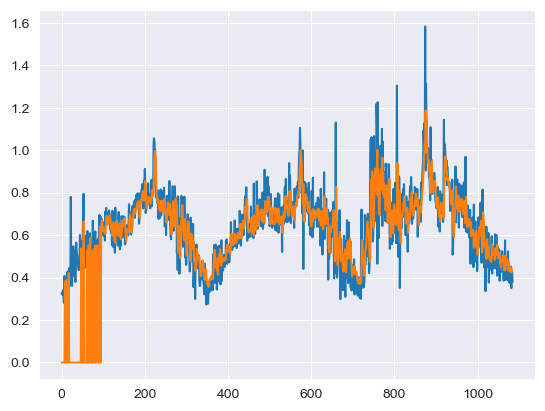

In [165]:
# 绘图
plt.plot(scaler.inverse_transform(scaled_data))
train_predict_plot = np.empty_like(scaled_data)
train_predict_plot[:, :] = np.nan
train_predict_plot[look_back:len(train_predict) + look_back, :] = train_predict

test_predict_plot = np.empty_like(scaled_data)

# print(scaler.inverse_transform(scaled_data))
test_predict_plot[len(train_predict) + (look_back * 1):len(scaled_data) - 1, :] = test_predict
# plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()

2. 建立LSTM模型
接下来，您需要定义LSTM的结构并编译模型。

3. 训练模型
使用您的训练数据训练LSTM模型。

4. 进行预测
使用训练好的LSTM模型对测试数据进行预测。

预测未来一周的销售量：

使用LSTM或其他时间序列预测模型预测每个蔬菜品类的未来一周销售量。
确定补货策略：

基于预测销售量，加上安全库存（以应对预测误差）来确定补货量。
考虑损耗率来进一步调整补货量。例如，如果某个蔬菜的损耗率为10%，那么您可能需要增加10%的补货量以应对这种损耗。
制定定价策略：

使用“成本加成定价”方法：先确定每个蔬菜品类的成本，然后加上预期的利润率来确定售价。
考虑市场竞争、季节性因素和其他因素来调整价格。
如果蔬菜品相变差，可以提供折扣以加速销售。
也可以考虑使用动态定价策略，例如，如果某天销售量低于预期，可以稍微降低价格以吸引更多顾客。
最大化收益的策略：

根据预测的销售量、定价策略和成本来模拟未来一周的预期收益。
使用优化算法（如线性规划）来确定能够最大化收益的最佳定价和补货策略。

In [18]:
import os
import zipfile
import datetime


def file2zip(packagePath, zipPath):
    '''
  :param packagePath: 文件夹路径
  :param zipPath: 压缩包路径
  :return:
  '''
    zip = zipfile.ZipFile(zipPath, 'w', zipfile.ZIP_DEFLATED)
    for path, dirNames, fileNames in os.walk(packagePath):
        fpath = path.replace(packagePath, '')
        for name in fileNames:
            fullName = os.path.join(path, name)
            name = fpath + '\\' + name
            zip.write(fullName, name)
    zip.close()

# if __name__ == "__main__":
#     # 文件夹路径
#     packagePath = '/kaggle/working/'
#     zipPath = '/kaggle/working/output.zip'
#     if os.path.exists(zipPath):
#         os.remove(zipPath)
#     file2zip(packagePath, zipPath)
#     print("打包完成")
#     print(datetime.datetime.utcnow())
